In [1]:
import numpy as np
import pandas as pd
import os

In [2]:
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from PIL import Image

In [3]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.layers import Flatten
from tensorflow.python.keras.layers import Dropout
from sklearn.metrics import accuracy_score
np.random.seed(42)

In [4]:
import keras_tuner as kt

from matplotlib import style
style.use('fivethirtyeight')

## Loading the Data:

In [31]:
data_dir = (r'C:\Users\kushw\Independent study Project')
train_path = (r'C:\Users\kushw\Independent study Project\Train')
test_path = (r'C:\Users\kushw\Independent study Project\Test')

## Resizing the Images:

In [6]:
# Resizing the images to 30x30x3
IMG_HEIGHT = 50
IMG_WIDTH = 50
channels = 3

In [7]:
NUM_CATEGORIES = len(os.listdir(train_path))
print("this is the number of sign class")
NUM_CATEGORIES

this is the number of sign class


43

In [8]:
# Label Overview finded on internet
classes = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)', 
            2:'Speed limit (50km/h)', 
            3:'Speed limit (60km/h)', 
            4:'Speed limit (70km/h)', 
            5:'Speed limit (80km/h)', 
            6:'End of speed limit (80km/h)', 
            7:'Speed limit (100km/h)', 
            8:'Speed limit (120km/h)', 
            9:'No passing', 
            10:'No passing veh over 3.5 tons', 
            11:'Right-of-way at intersection', 
            12:'Priority road', 
            13:'Yield', 
            14:'Stop', 
            15:'No vehicles', 
            16:'Veh > 3.5 tons prohibited', 
            17:'No entry', 
            18:'General caution', 
            19:'Dangerous curve left', 
            20:'Dangerous curve right', 
            21:'Double curve', 
            22:'Bumpy road', 
            23:'Slippery road', 
            24:'Road narrows on the right', 
            25:'Road work', 
            26:'Traffic signals', 
            27:'Pedestrians', 
            28:'Children crossing', 
            29:'Bicycles crossing', 
            30:'Beware of ice/snow',
            31:'Wild animals crossing', 
            32:'End speed + passing limits', 
            33:'Turn right ahead', 
            34:'Turn left ahead', 
            35:'Ahead only', 
            36:'Go straight or right', 
            37:'Go straight or left', 
            38:'Keep right', 
            39:'Keep left', 
            40:'Roundabout mandatory', 
            41:'End of no passing', 
            42:'End no passing veh > 3.5 tons' }

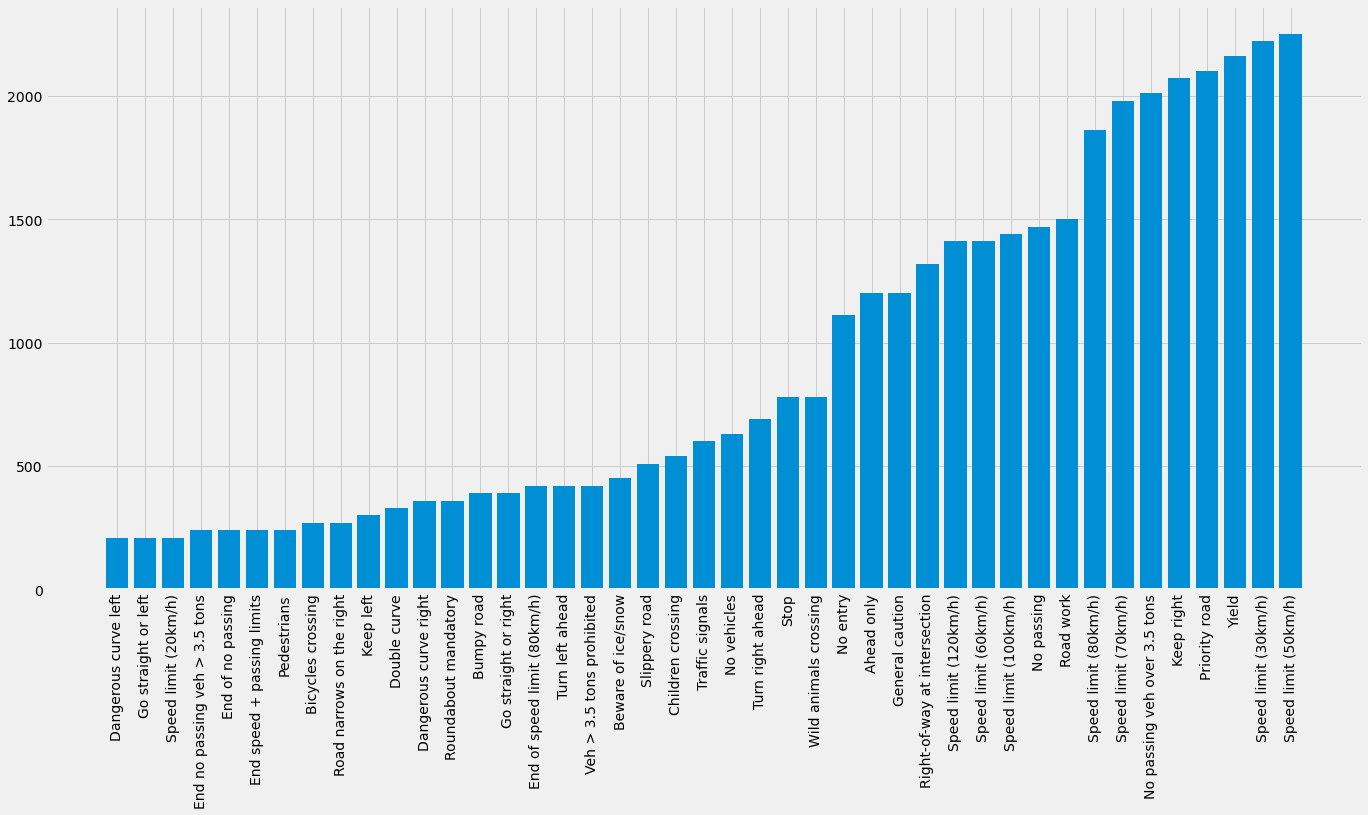

In [9]:
#we see the distribution of our classes in the training set
folders = os.listdir(train_path)

train_number = []
class_num = []

for folder in folders:
    train_files = os.listdir(train_path + '/' + folder)
    train_number.append(len(train_files))
    class_num.append(classes[int(folder)])
    
# Sorting the dataset on the basis of number of images in each class
zipped_lists = zip(train_number, class_num)
sorted_pairs = sorted(zipped_lists)
tuples = zip(*sorted_pairs)
train_number, class_num = [ list(tuple) for tuple in  tuples]

# Plotting the number of images in each class
plt.figure(figsize=(21,10))  
plt.bar(class_num, train_number)
plt.xticks(class_num, rotation='vertical')
plt.show()

C:\Users\kushw\AppData\Local\Temp\ipykernel_29816\3622557811.py:15: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=None)


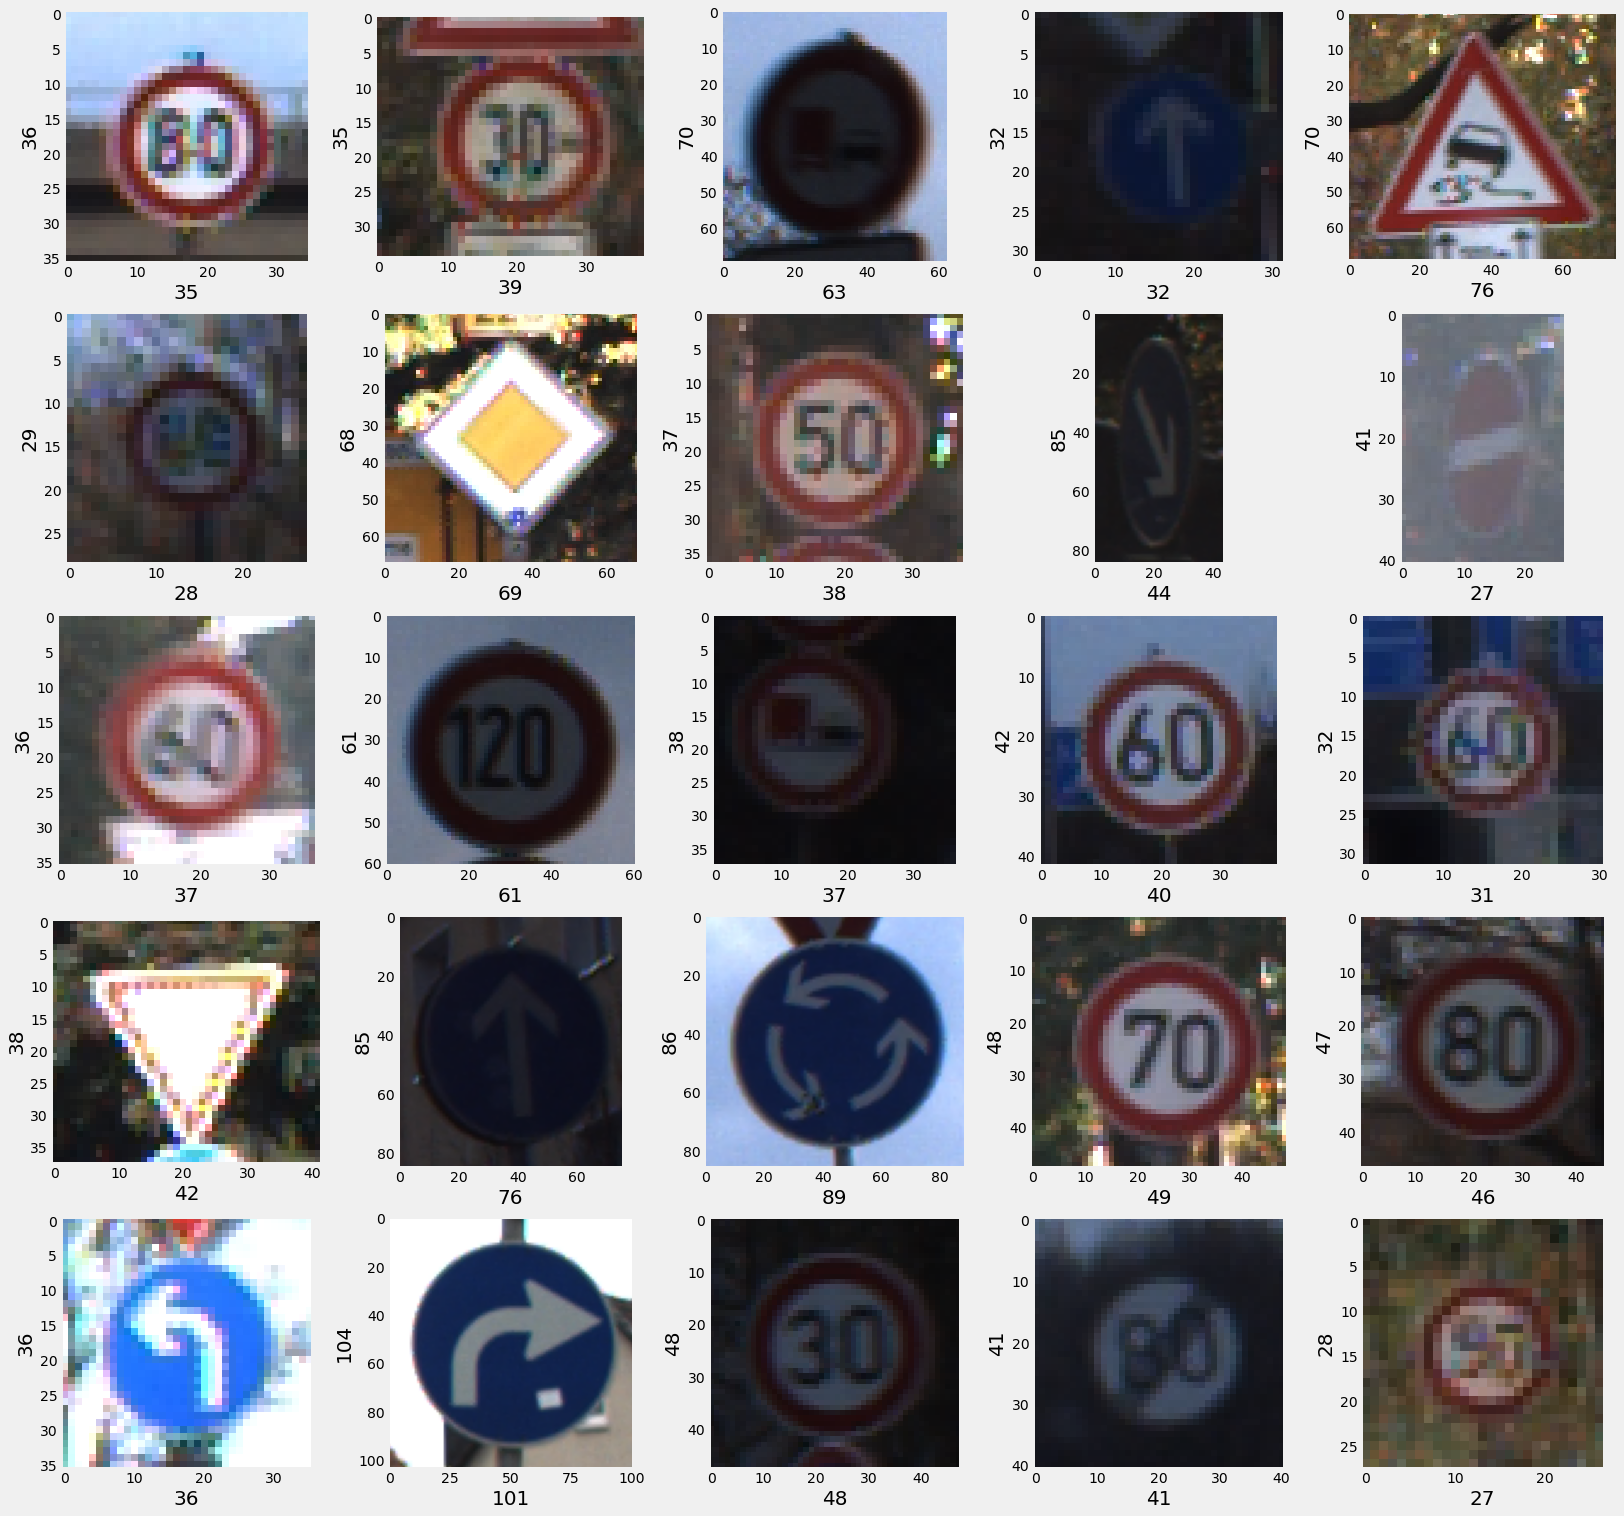

In [10]:
# Visualizing 25 random images from test data
import random
from matplotlib.image import imread

test = pd.read_csv( 'Test.csv')
imgs = test["Path"].values

plt.figure(figsize=(25,25))

for i in range(1,26):
    plt.subplot(5,5,i)
    random_img_path =  random.choice(imgs)
    rand_img = imread(random_img_path)
    plt.imshow(rand_img)
    plt.grid(b=None)
    plt.xlabel(rand_img.shape[1], fontsize = 20)#width of image
    plt.ylabel(rand_img.shape[0], fontsize = 20)#height of image

In [11]:
#we put all image with classes in np array
image_data = []
image_labels = []

for i in range(NUM_CATEGORIES):
    path = data_dir + '/Train/' + str(i)
    images = os.listdir(path)

    for img in images:
        try:
            image = cv2.imread(path + '/' + img)
            image_fromarray = Image.fromarray(image, 'RGB')
            resize_image = image_fromarray.resize((IMG_HEIGHT, IMG_WIDTH))
            image_data.append(np.array(resize_image))
            image_labels.append(i)
        except:
            print("Error in " + img)

In [12]:
# Changing the list to numpy array
image_data = np.array(image_data)
image_labels = np.array(image_labels)

print(image_data.shape, image_labels.shape)

(39209, 50, 50, 3) (39209,)


In [13]:
#we mix the array, so when we go to create train, test and validation, we avoid having a predominance of classes
shuffle_indexes = np.arange(image_data.shape[0])
np.random.shuffle(shuffle_indexes)
image_data = image_data[shuffle_indexes]
image_labels = image_labels[shuffle_indexes]

In [14]:
#we split the train and test set , 80 - 20 
X_train, X_val, y_train, y_val = train_test_split(image_data, image_labels, test_size=0.2, random_state=42, shuffle=True)

X_train = X_train/255 
X_val = X_val/255

print("X_train.shape", X_train.shape)
print("X_valid.shape", X_val.shape)
print("y_train.shape", y_train.shape)
print("y_valid.shape", y_val.shape)

X_train.shape (31367, 50, 50, 3)
X_valid.shape (7842, 50, 50, 3)
y_train.shape (31367,)
y_valid.shape (7842,)


In [15]:
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight(class_weight = "balanced",
                                                  classes = np.unique(y_train),
                                                  y = y_train)

# the field class weight in model.fit() is a dictionary, so we convert class_weights into a dictionary
class_weights = {i : class_weights[i] for i in range(len(class_weights))}

In [16]:
#is maded the one hot encoding to train the keras model
y_train = keras.utils.to_categorical(y_train, NUM_CATEGORIES)
y_val = keras.utils.to_categorical(y_val, NUM_CATEGORIES)

print(y_train.shape)
print(y_val.shape)

(31367, 43)
(7842, 43)


In [17]:
#Early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_prc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

## MLP

In [36]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

In [41]:
# build mlp classifier
mlp_model = MLPClassifier(hidden_layer_sizes=[21,36], 
                          activation='relu', 
                          early_stopping=True,
                          random_state=13, 
                          verbose= True)

# fit the model
%time mlp_model.fit(X_train, y_train)

ValueError: Found array with dim 4. Estimator expected <= 2.

In [39]:
from tensorflow import keras
from tensorflow.keras import layers
#we made the model with the augmentation layer

model = keras.models.Sequential()
model.add(keras.layers.Conv2D(filters=32,kernel_size=3,activation='relu', input_shape = [50, 50,3]))
model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))
model.add(keras.layers.Conv2D(filters=64 , activation='relu',kernel_size=3))
model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))
model.add(keras.layers.Conv2D(filters=128 , activation='relu' ,kernel_size=3))
model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(250,activation='relu'))
model.add(keras.layers.Dense(43,activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 22, 22, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 11, 11, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 9, 9, 128)         73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 4, 4, 128)        0

In [45]:
from sklearn.neural_network import MLPClassifier
mlp_classifier = mlp.Mlp(size_layers= [50, 50,3],
                        act_funt = 'relu',
                        reg_lambada = 0,
                        bias_flag = true)
print(mlp_classifier)

NameError: name 'mlp' is not defined

In [46]:
from sklearn.neural_network import MLPClassifier

# Instantiate an MLPClassifier object with the desired hyperparameters
mlp = MLPClassifier(hidden_layer_sizes=(100, 50), activation='relu', solver='adam', max_iter=500)

# Train the MLP model on your dataset
mlp.fit(X_train, y_train)

# Make predictions using the trained model
y_pred = mlp.predict(X_test)

ValueError: Found array with dim 4. Estimator expected <= 2.

In [ ]:
import imageio as iio
 
# read an image
img = iio.imread("C:\Users\kushw\Independent study Project\Test")
 
# write it in a new format
iio.imwrite("g4g.jpg", img)